In [1]:
import shap
import pandas as pd
import seaborn as sns
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

shap.initjs()

In [2]:
def normalize(factual, cfactual, oriFactual, oriCFactual):
    
    globalMin = np.min(pd.concat((oriFactual, oriCFactual)))
    globalMax = np.max(pd.concat((oriFactual, oriCFactual)))
    
    return (factual - globalMin) / (globalMax - globalMin), (cfactual - globalMin) / (globalMax - globalMin)

In [3]:
# Copy from https://github.com/AMLab-Amsterdam/CEVAE/evaluation.py
class Evaluator(object):
    def __init__(self, y, t, y_cf=None, mu0=None, mu1=None):
        self.y = y
        self.t = t
        self.y_cf = y_cf
        self.mu0 = mu0
        self.mu1 = mu1
        if mu0 is not None and mu1 is not None:
            self.true_ite = mu1 - mu0

    def rmse(self, yPred, yPredCF):
        F = np.sqrt(np.mean((self.y - yPred) ** 2))
        CF = np.sqrt(np.mean((self.y_cf - yPredCF) ** 2))
        total = np.sqrt(np.mean((self.y - yPred) ** 2) + np.mean(self.y_cf - yPredCF) ** 2)
        return F, CF, total
    
    def rmse_ite(self, ypred1, ypred0):
        pred_ite = np.zeros_like(self.true_ite)
        idx1, idx0 = np.where(self.t == 1), np.where(self.t == 0)
        ite1, ite0 = self.y[idx1] - ypred0[idx1], ypred1[idx0] - self.y[idx0]
        pred_ite[idx1] = ite1
        pred_ite[idx0] = ite0
        return np.sqrt(np.mean(np.square(self.true_ite - pred_ite)))

    def abs_ate(self, ypred1, ypred0):
        return np.abs(np.mean(ypred1 - ypred0) - np.mean(self.true_ite))

    def pehe(self, ypred1, ypred0):
        return np.sqrt(np.mean(np.square((self.mu1 - self.mu0) - (ypred1 - ypred0))))

    def getPredITE(self, ypred1, ypred0):
        pred_ite = np.zeros_like(self.true_ite)
        idx1, idx0 = np.where(self.t == 1), np.where(self.t == 0)
        ite1, ite0 = self.y[idx1] - ypred0[idx1], ypred1[idx0] - self.y[idx0]
        pred_ite[idx1] = ite1
        pred_ite[idx0] = ite0
        return pred_ite

In [4]:
caseType = 2
rmseFac = {
    1: [],
    2: [],
    3: [],
}
rmseCFac = {
    1: [],
    2: [],
    3: [],
}
ite = {
    1: [],
    2: [],
    3: [],
}
ate = {
    1: [],
    2: [],
    3: [],
}
pehe = {
    1: [],
    2: [],
    3: [],
}

In [5]:
for caseType in [1, 2, 3]:
    for i in range(50):
        txtSubname = "{:06d}".format(i)
        print(txtSubname)
        totalData = pd.read_csv('./massiveData/totalData_intCoef{}.csv'.format(txtSubname)).iloc[:, 1:]
        coef = np.loadtxt('./massiveData/coef_intCoef{}.txt'.format(txtSubname))
        B_sex, B_trt, B_age, B_int = coef[0], coef[1], coef[2], coef[3]
        
        
        totalData["y{}".format(caseType)], totalData["y{}CF".format(caseType)] = normalize(totalData["y{}".format(caseType)], 
                                                                                           totalData["y{}CF".format(caseType)], 
                                                                                           totalData["yo{}".format(caseType)], 
                                                                                           totalData["yo{}CF".format(caseType)])
        totalData["yo{}".format(caseType)], totalData["yo{}CF".format(caseType)] = normalize(totalData["yo{}".format(caseType)], 
                                                                                             totalData["yo{}CF".format(caseType)], 
                                                                                             totalData["yo{}".format(caseType)], 
                                                                                             totalData["yo{}CF".format(caseType)])
            
        
        X = totalData[["T", "Age", "Sex"]]
        y = totalData["y"+str(caseType)]
    
        #Train model
        model = xgb.XGBRegressor(objective="reg:squarederror",max_depth=2)
        model.fit(X, y)
    
        #Predict factual and counterfactual
        y_pred = model.predict(X)
        cfX = X.copy()
        cfX.iloc[:, 0] = 1 - cfX.iloc[:, 0]
        ycf_pred = model.predict(cfX)
    
        explainer = shap.TreeExplainer(model)
        shap_interaction = explainer.shap_interaction_values(X, tree_limit=-1)
        np.save("./massiveData/shapInteraction/Case{}-{:06d}.npy".format(caseType, i), shap_interaction)
    
        # Get absolute mean of matrices
        mean_shap = np.abs(shap_interaction).mean(0)
        df = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)
        df.where(df.values == np.diagonal(df),df.values*2,inplace=True)
    
        xt0 = X.copy()
        xt0["T"] = 0
        xt1 = X.copy()
        xt1["T"] = 1
        ypred0 = model.predict(xt0)
        ypred1 = model.predict(xt1)

        data = totalData
        mu1, mu0 = np.zeros(ypred0.shape), np.zeros(ypred0.shape)
        mu1[X["T"] == 1] = data["yo{}".format(caseType)][X["T"] == 1]
        mu1[X["T"] == 0] = data["yo{}CF".format(caseType)][X["T"] == 0]
        mu0[X["T"] == 0] = data["yo{}".format(caseType)][X["T"] == 0]
        mu0[X["T"] == 1] = data["yo{}CF".format(caseType)][X["T"] == 1]

        eva = Evaluator(y=np.array(data["y{}".format(caseType)]), 
                        t=np.array(data["T"]), 
                        y_cf=np.array(data["y{}CF".format(caseType)]), 
                        mu0=mu0, 
                        mu1=mu1)

        rmse1, rmse2, _ = eva.rmse(yPred=y_pred, yPredCF=ycf_pred)
        rmseFac[caseType].append(rmse1)
        rmseCFac[caseType].append(rmse2)
        ite[caseType].append(eva.rmse_ite(ypred1=ypred1, ypred0=ypred0))
        ate[caseType].append(eva.abs_ate(ypred1=ypred1, ypred0=ypred0))
        pehe[caseType].append(eva.pehe(ypred1=ypred1, ypred0=ypred0))
    
        # ===== clean the model and figure===== #
        del(model)

000000
000001
000002
000003
000004
000005
000006
000007
000008
000009
000010
000011
000012
000013
000014
000015
000016
000017
000018
000019
000020
000021
000022
000023
000024
000025
000026
000027
000028
000029
000030
000031
000032
000033
000034
000035
000036
000037
000038
000039
000040
000041
000042
000043
000044
000045
000046
000047
000048
000049
000000
000001
000002
000003
000004
000005
000006
000007
000008
000009
000010
000011
000012
000013
000014
000015
000016
000017
000018
000019
000020
000021
000022
000023
000024
000025
000026
000027
000028
000029
000030
000031
000032
000033
000034
000035
000036
000037
000038
000039
000040
000041
000042
000043
000044
000045
000046
000047
000048
000049
000000
000001
000002
000003
000004
000005
000006
000007
000008
000009
000010
000011
000012
000013
000014
000015
000016
000017
000018
000019
000020
000021
000022
000023
000024
000025
000026
000027
000028
000029
000030
000031
000032
000033
000034
000035
000036
000037
000038
000039
000040
000041
000042

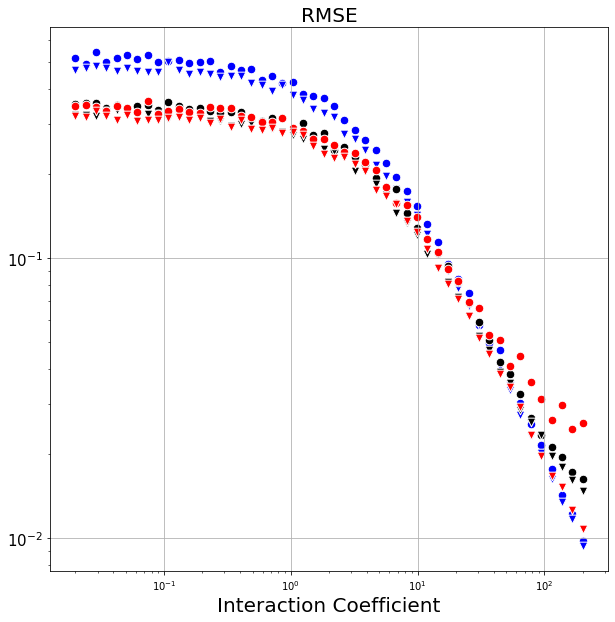

In [33]:
color=["blue", "black", "red"]
plt.figure(figsize=(10, 10))#, dpi=250)
plt.grid(True)
intCoef = np.array([2 * (10 ** x) for x in np.linspace(-2, 2, 50)])
for i in [1, 2, 3]:
    plt.scatter(intCoef, rmseCFac[i], c=color[i-1], label="case {}".format(i), s=75, edgecolor='white')
    plt.scatter(intCoef, rmseFac[i], c=color[i-1], marker="v", label="case {}".format(i), s=75, edgecolor='white')
#plt.scatter(np.arange(len(rmseCFac[i])), rmseCFac[i], s=i,label="case 2")
#plt.scatter(np.arange(len(rmseCFac[i])), rmseCFac[i], s=i, label="case 3")
plt.yscale('log')
plt.xscale('log')
plt.title("RMSE", fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel("Interaction Coefficient", fontsize=20)
plt.yticks(fontsize=15)
plt.show()

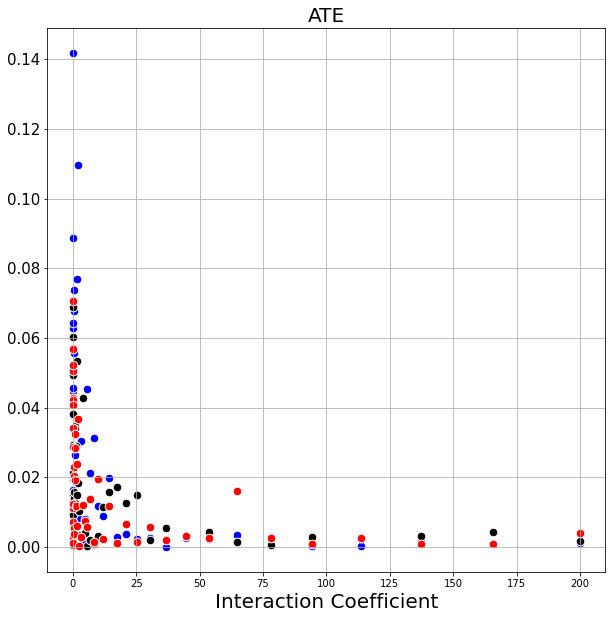

In [34]:
color=["blue", "black", "red"]
plt.figure(figsize=(10, 10))#, dpi=250)
plt.grid(True)
intCoef = np.array([2 * (10 ** x) for x in np.linspace(-2, 2, 50)])
for i in [1, 2, 3]:
    plt.scatter(intCoef, ate[i], c=color[i-1], label="case {}".format(i), s=75, edgecolor='white')
plt.title("ATE", fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel("Interaction Coefficient", fontsize=20)
plt.yticks(fontsize=15)
plt.show()

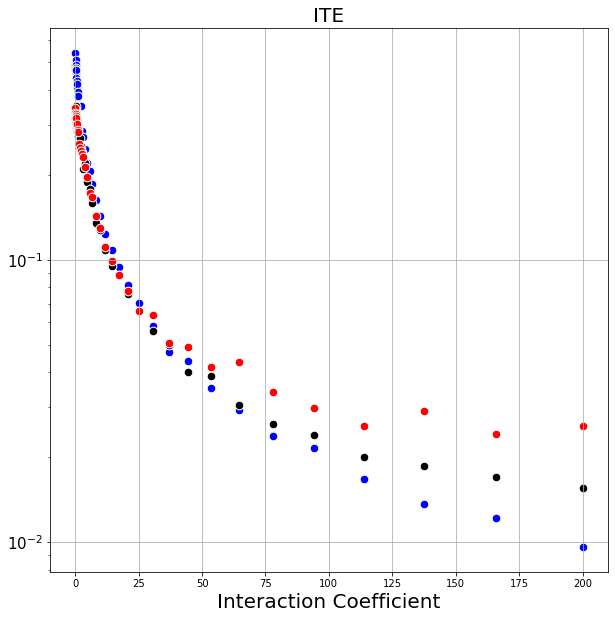

In [36]:
color=["blue", "black", "red"]
plt.figure(figsize=(10, 10))#, dpi=250)
plt.grid(True)
intCoef = np.array([2 * (10 ** x) for x in np.linspace(-2, 2, 50)])
for i in [1, 2, 3]:
    plt.scatter(intCoef, ite[i], c=color[i-1], label="case {}".format(i), s=75, edgecolor='white')
plt.title("ITE", fontsize=20)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.xlabel("Interaction Coefficient", fontsize=20)
plt.yticks(fontsize=15)
plt.show()

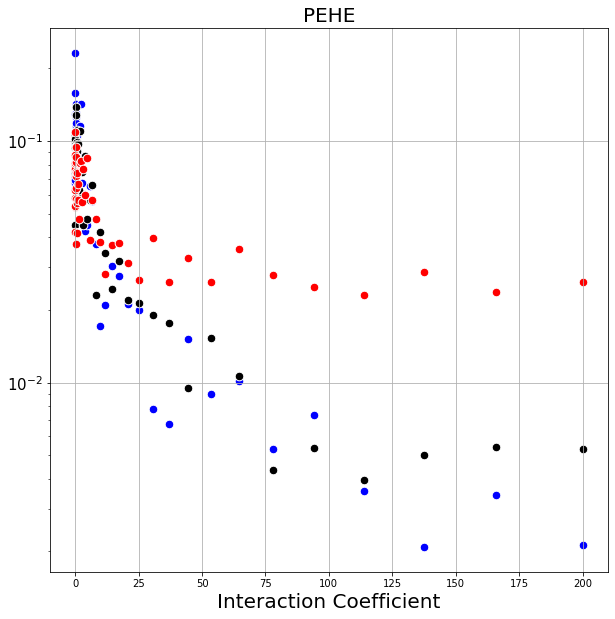

In [38]:
color=["blue", "black", "red"]
plt.figure(figsize=(10, 10))#, dpi=250)
plt.grid(True)
intCoef = np.array([2 * (10 ** x) for x in np.linspace(-2, 2, 50)])
for i in [1, 2, 3]:
    plt.scatter(intCoef, pehe[i], c=color[i-1], label="case {}".format(i), s=75, edgecolor='white')
plt.title("PEHE", fontsize=20)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.xlabel("Interaction Coefficient", fontsize=20)
plt.yticks(fontsize=15)
plt.show()